# Facial Expression Recognition Using CNN

Dataset from https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset

### **Abstract**

Facial Expression Recognition using **Convolutional Neural Network** explores interpreting human emotions from images. This notebook builds and trains a **CNN** to detect 7 different expressions: [Angry, Disgust, Fear, happy, Neutral, Sad, Surprise]. We evaluate its performance and save the model for real-world application together with other models.

### **Imports Libararies**.

Imports necessary libraries for building and training a convolutional neural network (CNN) for facial expression recognition.

In [80]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, MaxPooling2D, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [30]:
# Dataset Directory
data_dir = "images/train"


In [31]:
# Classes
sub_folders = os.listdir(data_dir)
sub_folders

['surprise', 'disgust', 'happy', 'neutral', 'fear', 'sad', 'angry']

In [32]:
# Declaring the lists for images and labels
images = []
labels = []

This code snippet iterates through each sub-folder in the `sub_folders` list, representing different classes or labels. It then accesses the images within each sub-folder, reads them using OpenCV, and appends them to the `images` list. Additionally, it appends the corresponding label (the name of the sub-folder) to the `labels` list. We run this twice to artificially increase the dataset. We can do this since we will later transorm the images so we won't get 2 images that look exactly the same.

In [33]:
# Accessing the labels
for i in range(0, 2):
    for sub_folder in sub_folders:
        label = sub_folder

        # Constructing the path to the current sub-folder
        path = os.path.join(data_dir, sub_folder)

        # Listing all images in the current sub-folder
        sub_folder_images = os.listdir(path)
        print(sub_folder + ": " + str(len(sub_folder_images)))

        # Accessing the Images
        for image_name in sub_folder_images:
            # Constructing the path to the current image
            image_path = os.path.join(path, image_name)
            # Loading the image using OpenCV
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
            # Appending the image to the list of images
            images.append(img)
            # Appending the label corresponding to the current sub-folder to the list of labels
            labels.append(label)

surprise: 3206
disgust: 550
happy: 7165
neutral: 4982
fear: 4104
sad: 4938
angry: 3993
surprise: 3206
disgust: 550
happy: 7165
neutral: 4982
fear: 4104
sad: 4938
angry: 3993


The lists of images and labels are converted to NumPy arrays using the `np.array()` function. This conversion is necessary for further processing and compatibility with deep learning frameworks like TensorFlow and Keras.

In [34]:
# Converting the lists of images and labels to NumPy arrays
images = np.array(images)
labels = np.array(labels)
print(len(images))

57876


The dataset is split into training, validation, and test sets using the `train_test_split` function from scikit-learn.

- `X_train`, `y_train`: Training images and labels.
- `X_val`, `y_val`: Validation images and labels.
- `X_test`, `y_test`: Test images and labels.

The dataset is split with a test size of 20% and a validation size of 10% of the original dataset. The `random_state` parameter ensures reproducibility of the split.

In [35]:
# Splitting Dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

The `preprocessing` function is defined to preprocess the input images before feeding them into the neural network model.

- Normalize the pixel values by dividing each pixel by 255.0, which scales the pixel values to the range [0, 1].
- Resize the image to a fixed size of 48x48 pixels using OpenCV's `resize` function.
- Reshape the image array to match the input shape expected by the neural network model. The shape is `(batch_size, height, width, channels)`, where `batch_size` is set to `-1` to indicate a dynamic batch size, and `channels` is set to 1 for grayscale images.

In [36]:
# Preprocess the image
def preprocessing(img):
    img = img / 255.0
    img = cv2.resize(img, (48, 48))
    return img.reshape(-1, 48, 48, 1)  # Reshape to match input shape

The code snippet applies the `preprocessing` function to each image in the training, validation, and test sets using the `map` function, and then converts the resulting list of preprocessed images into NumPy arrays.

- `map(preprocessing, X_train)`: Applies the `preprocessing` function to each image in `X_train`.
- `list(map(...))`: Converts the map object to a list.
- `np.array(...)`: Converts the list of preprocessed images to a NumPy array.

In [37]:
# Apply preprocessing to training, validation, and test sets
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

The code reshapes the input data arrays to remove an unnecessary dimension. Since the input shape expected by the neural network model is `(batch_size, height, width, channels)`, where `batch_size` represents the number of samples in each batch, the extra dimension is removed to ensure compatibility with the model architecture.

- `reshape(-1, 48, 48, 1)`: Reshapes the input data arrays to have a shape of `(batch_size, 48, 48, 1)`, where `-1` indicates that the batch size is dynamically determined based on the number of samples.

In [38]:
# Reshape input data to remove unnecessary dimension
X_train = X_train.reshape(-1, 48, 48, 1)
X_val = X_val.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

The `ImageDataGenerator` object is initialized with various data augmentation parameters to augment the training images. Data augmentation is a technique used to artificially increase the size of the training dataset by applying random transformations to the images, which helps improve the model's generalization and robustness.

- `width_shift_range`: Randomly shifts the width of the image by a fraction of its width.
- `height_shift_range`: Randomly shifts the height of the image by a fraction of its height.
- `zoom_range`: Randomly zooms into or out of the image.
- `shear_range`: Randomly applies shear transformation to the image.
- `rotation_range`: Randomly rotates the image by a specified angle range.

The `fit()` method is then called on the `ImageDataGenerator` object to compute statistics necessary for data augmentation based on the training data.

In [39]:
# Initialize ImageDataGenerator for data augmentation
data_gen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    rotation_range=20
)

# Compute necessary statistics for data augmentation
data_gen.fit(X_train)

The `LabelEncoder` object is initialized to encode the class labels into numerical values. This is necessary because machine learning models typically require numerical inputs. The `fit()` method is then called on the `LabelEncoder` object to fit the encoder to the array of class labels, enabling it to map class labels to numerical values.

In [40]:
# Encode the class labels
label_encoder = LabelEncoder()
label_encoder.fit(labels)

LabelEncoder()

The class labels for the training, validation, and test sets are encoded using the `transform()` method of the `LabelEncoder` object initialized earlier. This method maps the class labels to their corresponding numerical values as determined during the fitting process.

In [41]:
# Encode the class labels for training, validation, and test sets
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

The variable `num_classes` is assigned the number of unique classes in the dataset, which is determined by the length of the `classes_` attribute of the `LabelEncoder` object.

The `to_categorical()` function is then used to convert the encoded class labels into one-hot encoded categorical arrays. This transformation is necessary for multi-class classification tasks, where each class label is represented as a binary vector with a 1 in the position corresponding to the class index and 0s elsewhere.

In [42]:
# Get the number of classes
num_classes = len(label_encoder.classes_)

# Convert encoded class labels to one-hot encoded categorical arrays
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_val_categorical = to_categorical(y_val, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

The `build_model` function defines the architecture of the convolutional neural network (CNN) for facial expression recognition.

- **1st Layer**: Convolutional layer with 64 filters of size (5, 5), ReLU activation, and batch normalization. MaxPooling and Dropout layers are added for regularization.

- **2nd Layer**: Convolutional layer with 128 filters of size (3, 3), ReLU activation, and batch normalization. MaxPooling and Dropout layers are added for regularization.

- **3rd Layer**: Convolutional layer with 512 filters of size (3, 3), ReLU activation, and batch normalization. MaxPooling and Dropout layers are added for regularization.

- **4th Layer**: Convolutional layer with 512 filters of size (3, 3), ReLU activation, and batch normalization. MaxPooling and Dropout layers are added for regularization.

- **Flatten Layer**: Flatten the output from the convolutional layers to be fed into the fully connected layers.

- **Fully Connected Layer 1**: Dense layer with 256 units and ReLU activation, followed by batch normalization and dropout for regularization.

- **Fully Connected Layer 2**: Dense layer with 512 units and ReLU activation, followed by batch normalization and dropout for regularization.

- **Output Layer**: Dense layer with softmax activation for multi-class classification, with the number of units equal to the number of classes in the dataset.

- **Compilation**: The model is compiled with the Adam optimizer, categorical cross-entropy loss function, and accuracy metric.

In [43]:
# Building Model
def build_model():
    model = Sequential()
    # 1st Layer
    model.add(Conv2D(64, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(48, 48, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.4))

    # 2nd Layer
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.4))

    # 3rd layer
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.4))

    # 4th layer
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.4))

    # Flatten Layer
    model.add(Flatten())

    # Fully connected layer 1
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    # Fully connected layer 2
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

The `summary()` method is called on the built model to display a summary of its architecture, including the layers, output shapes, and the number of trainable parameters.

In [44]:
# Build the model
model = build_model()

# Print model summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization_6 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_7 (Bat  (None, 24, 24, 128)      

The `ModelCheckpoint` callback is initialized to save the model weights during training. It monitors the validation accuracy (`val_acc`) and saves only the best model (determined by the maximum validation accuracy) to the specified file `"model.h5"`.

In [45]:
# Initialize ModelCheckpoint callback
checkpoint = ModelCheckpoint("model.h5", monitor="val_accuracy", verbose=1, save_best_only=True)
# Initialize ModelCheckpoint callback
# checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", verbose=1, save_best_only=True)

The `EarlyStopping` callback is initialized to monitor the validation loss (`val_loss`). It stops the training process if the validation loss does not improve for a certain number of epochs (`patience`) specified by the user. The training is stopped early to prevent overfitting, and the weights of the best performing model are restored (`restore_best_weights=True`).

In [46]:
# Initialize EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    restore_best_weights=True
)

The `ReduceLROnPlateau` callback is initialized to dynamically adjust the learning rate during training based on the validation loss (`val_loss`). If the validation loss does not improve for a certain number of epochs (`patience`), the learning rate is reduced by a factor specified by the user (`factor`). This helps improve the training process and prevent the model from getting stuck in local minima.

In [47]:
# Initialize ReduceLROnPlateau callback
reduce_learningrate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_delta=0.0001
)

The `callbacks_list` is a list containing the callbacks to be used during the training of the model. It includes the `EarlyStopping`, `ModelCheckpoint`, and `ReduceLROnPlateau` callbacks, which are used to monitor the validation loss, save the best model, and adjust the learning rate, respectively.


In [48]:
# List of callbacks
callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

The `compile()` method is called on the model to configure the training process. It specifies the loss function, optimizer, and evaluation metrics to be used during training.

- **Loss Function**: Categorical cross-entropy is used as the loss function for multi-class classification problems.
- **Optimizer**: Adam optimizer is chosen with a learning rate of 0.001.
- **Metrics**: Accuracy is used as the evaluation metric to monitor the performance of the model during training.

In [49]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

The `fit()` method is called on the model to train it on the training data. It takes the following parameters:

- `data_gen.flow(X_train, y_train_categorical, batch_size=128)`: A generator that yields batches of augmented training data. Data augmentation is applied on-the-fly using the `ImageDataGenerator` object defined earlier.
- `validation_data=(X_val, y_val_categorical)`: Validation data to evaluate the model's performance after each epoch.
- `epochs=64`: The number of epochs to train the model.
- `verbose=1`: Specifies the verbosity mode. Here, it prints progress bars during training.

In [51]:
# Training the model
history = model.fit(
    data_gen.flow(X_train, y_train_categorical, batch_size=128),
    validation_data=(X_val, y_val_categorical),
    epochs=64,
    callbacks=callbacks_list
)

Epoch 1/64


2024-05-30 17:51:39.037131: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


122/290 [===========>..................] - ETA: 13s - loss: 2.3864 - accuracy: 0.1905

2024-05-30 17:51:51.382331: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-30 17:51:51.497533: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


290/290 [==============================] - ETA: 0s - loss: 2.1620 - accuracy: 0.2148
Epoch 1: val_accuracy improved from -inf to 0.14449, saving model to model.h5
290/290 [==============================] - 32s 98ms/step - loss: 2.1620 - accuracy: 0.2148 - val_loss: 3.7012 - val_accuracy: 0.1445 - lr: 0.0010
Epoch 2/64


/home/marcus/conda/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


290/290 [==============================] - ETA: 0s - loss: 1.8020 - accuracy: 0.2922
Epoch 2: val_accuracy improved from 0.14449 to 0.18445, saving model to model.h5
290/290 [==============================] - 26s 88ms/step - loss: 1.8020 - accuracy: 0.2922 - val_loss: 2.7456 - val_accuracy: 0.1844 - lr: 0.0010
Epoch 3/64
290/290 [==============================] - ETA: 0s - loss: 1.6455 - accuracy: 0.3591
Epoch 3: val_accuracy improved from 0.18445 to 0.40356, saving model to model.h5
290/290 [==============================] - 26s 88ms/step - loss: 1.6455 - accuracy: 0.3591 - val_loss: 1.5437 - val_accuracy: 0.4036 - lr: 0.0010
Epoch 4/64
290/290 [==============================] - ETA: 0s - loss: 1.5538 - accuracy: 0.3959
Epoch 4: val_accuracy improved from 0.40356 to 0.45054, saving model to model.h5
290/290 [==============================] - 26s 89ms/step - loss: 1.5538 - accuracy: 0.3959 - val_loss: 1.4423 - val_accuracy: 0.4505 - lr: 0.0010
Epoch 5/64
290/290 [======================

The trained model is saved to a file named `'modelv1.h5'` using the `save()` method. This file contains the model architecture, weights, and training configuration, allowing you to reload the model later for inference or further training.

In [ ]:
# Saving the model with .h5 extension
model.save('modelv1.h5')

The code snippet plots the model accuracy over epochs during training and validation. It visualizes how the model's performance changes over time and helps identify overfitting or underfitting.

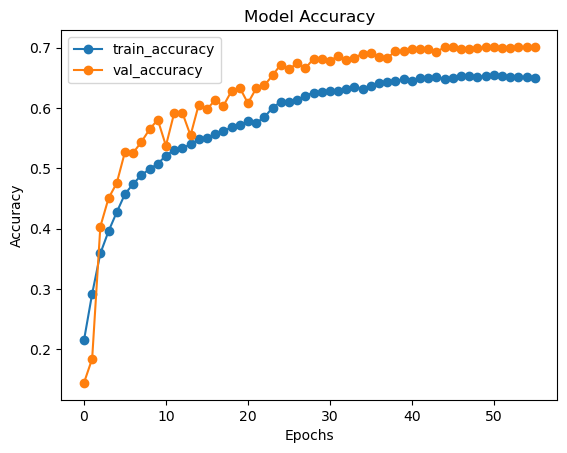

In [52]:
# Plotting model performance
plt.plot(history.history['accuracy'], label='train_accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='val_accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [70]:
Y_pred = model.predict(X_test)
Y_pred

362/362 [==============================] - 3s 8ms/step


array([[7.7013679e-02, 6.2659625e-03, 2.2835746e-01, ..., 1.7516254e-01,
        4.7761238e-01, 6.4512733e-03],
       [1.7164613e-03, 1.3317709e-05, 2.0452462e-02, ..., 1.3332929e-04,
        2.0373763e-04, 9.0298784e-01],
       [1.4811514e-01, 2.7758887e-01, 1.8473361e-01, ..., 9.2294335e-02,
        2.6773509e-01, 6.9110198e-03],
       ...,
       [7.8583413e-01, 2.1699509e-03, 6.4049311e-02, ..., 5.7082079e-02,
        4.2565748e-02, 1.1780936e-02],
       [6.7536738e-03, 1.0645600e-04, 5.4753829e-02, ..., 4.6073413e-03,
        2.9279687e-03, 9.2756289e-01],
       [4.2492156e-05, 1.8081326e-07, 7.2388831e-03, ..., 1.8850808e-06,
        1.2802539e-06, 9.9271166e-01]], dtype=float32)

In [71]:
y_pred = np.argmax(Y_pred, axis=1)
y_pred

array([5, 6, 1, ..., 0, 6, 6])

In [67]:
y_test

array([2, 6, 2, ..., 0, 6, 6])

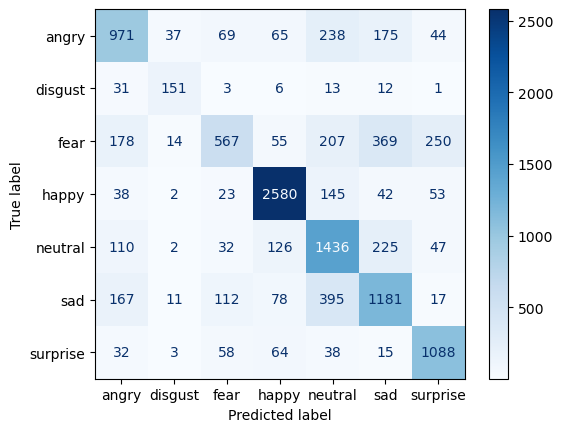

In [79]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)